In [36]:
%run Function_Master.ipynb
%run Parameterization.ipynb

#### Loading Solution and Function Call

In [37]:
%store -r sol

In [38]:
dfs = svs(sol, param)

In [39]:
# Example: P_I dataframe
dfs[3].head()

,Time (Days),P_I,Growth,Adsorption,Grazing --,Mortality --,NT Recycling --,Lysis --,Entrainment --,Sources,Sinks,dPidt
0,0.000000e+00,0.000000e+00,0.000000e+00,1.063670,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.063670,0.000000e+00,1.063670
1,2.972987e-07,3.162277e-07,4.086628e-07,1.063670,6.324553e-08,1.581138e-08,8.882803e-10,3.997261e-10,0.0,1.063670,8.034492e-08,1.063670
2,5.945973e-07,6.324552e-07,8.173255e-07,1.063669,1.264910e-07,3.162276e-08,1.776561e-09,7.994522e-10,0.0,1.063670,1.606898e-07,1.063670
3,1.967910e-03,2.090861e-03,2.701890e-03,1.059115,4.181640e-04,1.045430e-04,5.880022e-06,2.646010e-06,0.0,1.061817,5.312331e-04,1.061286
4,3.935225e-03,4.176421e-03,5.396649e-03,1.054588,8.352519e-04,2.088211e-04,1.175880e-05,5.291458e-06,0.0,1.059985,1.061123e-03,1.058924


### Plotting individual or combined sources and sinks for given state variable

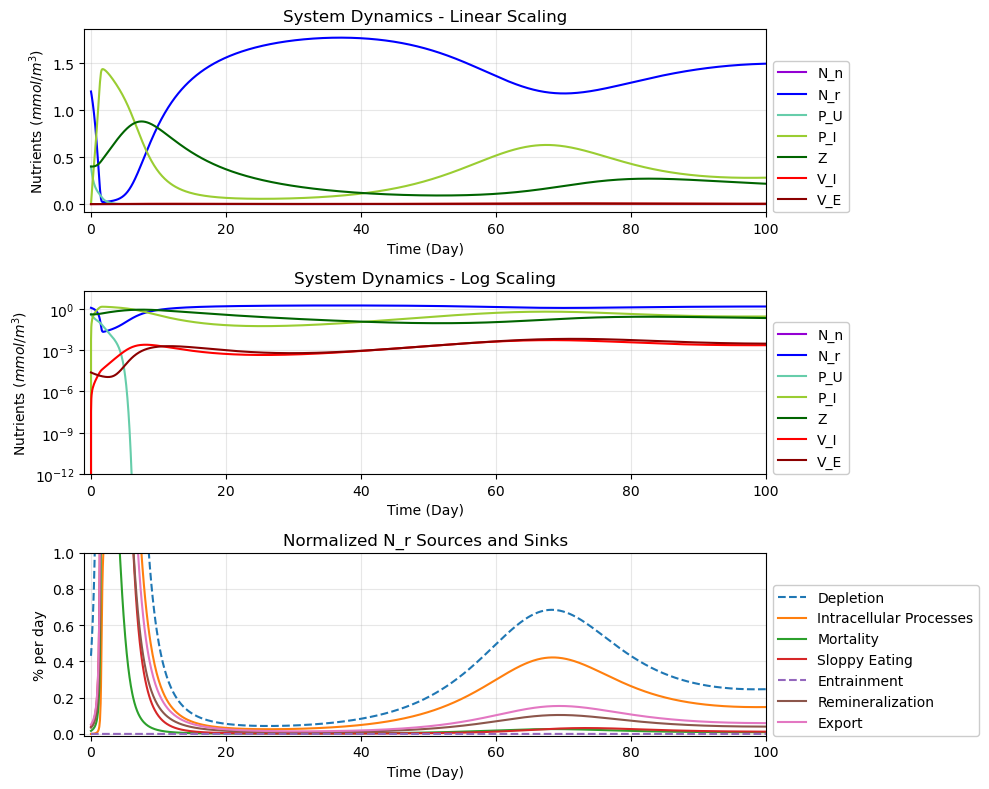

In [45]:
""" Plotting SVS for specified state """

fig, axs = plt.subplots(3, 1, figsize = (10, 8))

labels = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']
colors = ["darkviolet", "blue", "mediumaquamarine", "yellowgreen", "darkgreen", "red", "darkred"]

# Plotting states evolution
for i, df in enumerate(dfs):
    axs[0].plot(df["Time (Days)"], df[labels[i]], color=colors[i], label=labels[i])
    axs[1].plot(df["Time (Days)"], df[labels[i]], color=colors[i], label=labels[i])
    
""" assign index to 'state' accourding to label order """
state = 1
time_span = dfs[state]["Time (Days)"]

# Combined Sources and Sinks
# axs[2].plot(time_span, dfs[state]["Sources"] / dfs[state][labels[state]], color='black', label="Sources")
# axs[2].plot(time_span, dfs[state]["Sinks"] / dfs[state][labels[state]], '--', color='black', label="Sinks")
    
# Individual transfer terms
for column in dfs[state].columns[2:-3]:
    if '--' in column: 
        axs[2].plot(time_span, dfs[state][column] / dfs[state][labels[state]], '--', label=column[:-3])
    else: 
        axs[2].plot(time_span, dfs[state][column] / dfs[state][labels[state]], label=column)
    
# Axs specific settings
axs[0].set_title("System Dynamics - Linear Scaling")
axs[0].set_ylabel(r'Nutrients ($mmol/m^3$)')

axs[1].set_title("System Dynamics - Log Scaling")
axs[1].set_ylabel(r'Nutrients ($mmol/m^3$)')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-12, 20)

axs[2].set_title(f"Normalized {labels[state]} Sources and Sinks")
axs[2].set_ylabel('% per day')
axs[2].set_ylim(-.01, 1)

# Broad Axs settings   
for ax in axs:
    ax.set_xlabel('Time (Day)')
    ax.set_xlim(-1, 100)
    ax.grid(which='both', alpha=.3)
    ax.legend(loc=(1.01, 0), framealpha=1)
    
plt.tight_layout()
plt.show()